In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
PATH='data/'

In [3]:
!ls {PATH}

mnt  models  tmp  train_sample.csv  train_sample.csv(1).zip


In [4]:
X_train = pd.read_csv(f'{PATH}train_sample.csv', low_memory=False, 
                     parse_dates=["click_time"])

In [5]:
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9


In [7]:
FREQUENCY_COLUMNS = ['ip', 'app', 'device', 'os', 'channel']

In [8]:
freqs = {}
for col in FREQUENCY_COLUMNS:
    print(f">> Calculating frequency for: {col}")

    
    df = pd.DataFrame({
        'sums': X_train.groupby(col)['is_attributed'].sum(),
        'counts': X_train.groupby(col)['is_attributed'].count()
    })
    df.loc[:, 'freq'] = df.sums / df.counts
    
   
    df.loc[df.counts <= 3, 'freq'] = 0        
    

    X_train[col+'_freq'] = X_train[col].map(df['freq'])
    
X_train.head()

>> Calculating frequency for: ip
>> Calculating frequency for: app
>> Calculating frequency for: device
>> Calculating frequency for: os
>> Calculating frequency for: channel


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_freq,app_freq,device_freq,os_freq,channel_freq
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,0.0,0.000076,0.001548,0.001178,0.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,0.0,0.000000,0.001548,0.001147,0.0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,0.0,0.000076,0.001548,0.001718,0.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,0.0,0.000000,0.001548,0.001178,0.0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,0.0,0.000076,0.001548,0.000844,0.0


In [9]:
GROUPBY_AGGREGATIONS = [
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), spec['agg'], spec['select'])
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_train
    X_train = X_train.merge(gp, on=spec['groupby'], how='left')

X_train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,os_freq,channel_freq,ip_app_channel_var_day,ip_app_os_var_hour,ip_day_channel_var_hour,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,...,0.001178,0.0,NaN,24.5,NaN,1,3,2,1,9.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,...,0.001147,0.0,0.25,NaN,19.0,4,4,1,1,11.5
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,...,0.001718,0.0,NaN,NaN,NaN,1,1,1,1,18.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,...,0.001178,0.0,NaN,NaN,NaN,1,1,1,1,4.0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,...,0.000844,0.0,NaN,NaN,NaN,1,2,1,1,9.0


In [10]:
GROUP_BY_NEXT_CLICKS = [
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
]


for spec in GROUP_BY_NEXT_CLICKS:
    
   
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
   
    all_features = spec['groupby'] + ['click_time']
    
   
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
X_train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_day_channel_var_hour,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,...,NaN,1,3,2,1,9.0,61540.0,61540.0,NaN,61540.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,...,19.0,4,4,1,1,11.5,12747.0,8866.0,83778.0,4888.0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,...,NaN,1,1,1,1,18.0,57936.0,NaN,NaN,57936.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,...,NaN,1,1,1,1,4.0,19577.0,NaN,NaN,NaN
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,...,NaN,1,2,1,1,9.0,51097.0,53365.0,NaN,NaN


In [12]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

for fname, fset in HISTORY_CLICKS.items():
    
   
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]


X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_app_day_hour_count_channel,ip_app_channel_mean_hour,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,...,1,9.0,61540.0,61540.0,NaN,61540.0,0,0,0,2
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,...,1,11.5,12747.0,8866.0,83778.0,4888.0,0,0,0,3
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,...,1,18.0,57936.0,NaN,NaN,57936.0,0,0,0,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,...,1,4.0,19577.0,NaN,NaN,NaN,0,0,0,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,...,1,9.0,51097.0,53365.0,NaN,NaN,0,0,0,1


In [13]:
add_datepart(X_train, "click_time", drop=False)

In [14]:
X_train.head(20)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,...,7,1,311,False,False,False,False,False,False,1510047038
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,...,7,1,311,False,False,False,False,False,False,1510062027
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,...,7,1,311,False,False,False,False,False,False,1510077924
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,...,7,1,311,False,False,False,False,False,False,1510030688
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,...,9,3,313,False,False,False,False,False,False,1510218009
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0,9,1,...,9,3,313,False,False,False,False,False,False,1510190533
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0,9,1,...,9,3,313,False,False,False,False,False,False,1510190278
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0,7,10,...,7,1,311,False,False,False,False,False,False,1510048913
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0,8,9,...,8,2,312,False,False,False,False,False,False,1510133717
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0,8,12,...,8,2,312,False,False,False,False,False,False,1510144526


In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [16]:
display_all(X_train)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_freq,app_freq,device_freq,os_freq,channel_freq,ip_app_channel_var_day,ip_app_os_var_hour,ip_day_channel_var_hour,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeElapsed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,0.000000,0.000076,0.001548,0.001178,0.000000,NaN,24.500000,NaN,1,3,2,1,9.000000,61540.0,61540.0,NaN,61540.0,0,0,0,2,2017,11,45,7,1,311,False,False,False,False,False,False,1510047038
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,0.000000,0.000000,0.001548,0.001147,0.000000,0.250000,NaN,19.000000,4,4,1,1,11.500000,12747.0,8866.0,83778.0,4888.0,0,0,0,3,2017,11,45,7,1,311,False,False,False,False,False,False,1510062027
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,0.000000,0.000076,0.001548,0.001718,0.000000,NaN,NaN,NaN,1,1,1,1,18.000000,57936.0,NaN,NaN,57936.0,0,0,0,0,2017,11,45,7,1,311,False,False,False,False,False,False,1510077924
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,0.000000,0.000000,0.001548,0.001178,0.000000,NaN,NaN,NaN,1,1,1,1,4.000000,19577.0,NaN,NaN,NaN,0,0,0,0,2017,11,45,7,1,311,False,False,False,False,False,False,1510030688
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,0.000000,0.000076,0.001548,0.000844,0.000000,NaN,NaN,NaN,1,2,1,1,9.000000,51097.0,53365.0,NaN,NaN,0,0,0,1,2017,11,45,9,3,313,False,False,False,False,False,False,1510218009
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0,9,1,22,13,0.000000,0.000219,0.001548,0.001147,0.000000,NaN,NaN,NaN,1,1,1,1,1.000000,13239.0,NaN,NaN,NaN,0,0,0,0,2017,11,45,9,3,313,False,False,False,False,False,False,1510190533
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0,9,1,17,58,0.000000,0.000000,0.001548,0.001147,0.000000,NaN,NaN,NaN,1,1,1,1,1.000000,21269.0,NaN,NaN,78143.0,0,0,0,0,2017,11,45,9,3,313,False,False,False,False,False,False,1510190278
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0,7,10,1,53,0.000000,0.000890,0.001548,0.002224,0.000515,NaN,NaN,NaN,1,2,1,1,10.000000,52342.0,21644.0,NaN,NaN,0,0,0,1,2017,11,45,7,1,311,False,False,False,False,False,False,1510048913
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0,8,9,35,17,0.000000,0.000000,0.000460,0.001486,0.000000,1.000000,NaN,0.500000,1,5,1,1,13.800000,1648.0,1648.0,1648.0,NaN,0,0,0,4,2017,11,45,8,2,312,False,False,False,False,False,False,1510133717
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0,8,12,35,26,0.000000,0.000219,0.001548,0.001718,0.000000,NaN,NaN,NaN,1,1,1,1,12.000000,NaN,NaN,NaN,NaN,0,0,0,0,2017,11,45,8,2,312,False,False,False,False,False,False,1510144526


In [17]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second', 'ip_freq',
       'app_freq', 'device_freq', 'os_freq', 'channel_freq',
       'ip_app_channel_var_day', 'ip_app_os_var_hour',
       'ip_day_channel_var_hour', 'ip_day_hour_count_channel',
       'ip_app_count_channel', 'ip_app_os_count_channel',
       'ip_app_day_hour_count_channel', 'ip_app_channel_mean_hour',
       'ip_nextClick', 'ip_app_nextClick', 'ip_channel_nextClick',
       'ip_os_nextClick', 'prev_identical_clicks', 'future_identical_clicks',
       'prev_app_clicks', 'future_app_clicks', 'click_timeYear',
       'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear', 'click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start', 'click_timeElapsed'],
      dtype='o

In [19]:
cat_vars = ['click_timeIs_month_end',
       'click_timeIs_month_start', 'click_timeIs_quarter_end',
       'click_timeIs_quarter_start', 'click_timeIs_year_end',
       'click_timeIs_year_start','ip', 'app', 'device', 'os', 'channel','day',
            'hour', 'minute', 'second','click_timeYear',
       'click_timeMonth', 'click_timeWeek', 'click_timeDay',
       'click_timeDayofweek', 'click_timeDayofyear','ip_day_hour_count_channel',
       'ip_app_count_channel', 'ip_app_os_count_channel',
       'ip_app_day_hour_count_channel']

contin_vars = ['ip_freq',
       'app_freq', 'device_freq', 'os_freq', 'channel_freq',
       'ip_app_channel_var_day', 'ip_app_os_var_hour',
       'ip_day_channel_var_hour']
n=len(X_train)
n

100000

In [20]:
dep = 'is_attributed'
joined = X_train[cat_vars+contin_vars+[dep]].copy()

In [21]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()



In [22]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [23]:
train_cats(joined)


In [24]:
joined.is_attributed.dtype

dtype('int64')

In [25]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs]
samp_size = len(joined_samp); samp_size

100000

In [26]:
joined_samp.head(2)


,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,ip,app,device,os,...,ip_app_day_hour_count_channel,ip_freq,app_freq,device_freq,os_freq,channel_freq,ip_app_channel_var_day,ip_app_os_var_hour,ip_day_channel_var_hour,is_attributed
75721,False,False,False,False,False,False,48240,14,1,35,...,2,0.0,0.0,0.001548,0.001094,0.0,NaN,NaN,NaN,0
80184,False,False,False,False,False,False,88629,2,1,22,...,1,0.0,0.0,0.001548,0.001486,0.0,0.0,NaN,0.5,0


In [27]:
df, y, nas, mapper = proc_df(joined_samp, 'is_attributed', do_scale=True)

In [28]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [29]:
val_idx=[0]
y.dtype


dtype('int64')

In [43]:
from sklearn import metrics


In [41]:
def exp_rmspe(y_pred, targ):
    
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [31]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=64)
                                       

In [32]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('click_timeIs_month_end', 2),
 ('click_timeIs_month_start', 2),
 ('click_timeIs_quarter_end', 2),
 ('click_timeIs_quarter_start', 2),
 ('click_timeIs_year_end', 2),
 ('click_timeIs_year_start', 2),
 ('ip', 34858),
 ('app', 162),
 ('device', 101),
 ('os', 131),
 ('channel', 162),
 ('day', 5),
 ('hour', 25),
 ('minute', 61),
 ('second', 61),
 ('click_timeYear', 2),
 ('click_timeMonth', 2),
 ('click_timeWeek', 2),
 ('click_timeDay', 5),
 ('click_timeDayofweek', 5),
 ('click_timeDayofyear', 5),
 ('ip_day_hour_count_channel', 28),
 ('ip_app_count_channel', 59),
 ('ip_app_os_count_channel', 24),
 ('ip_app_day_hour_count_channel', 9)]

In [33]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs


[(2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (34858, 50),
 (162, 50),
 (101, 50),
 (131, 50),
 (162, 50),
 (5, 3),
 (25, 13),
 (61, 31),
 (61, 31),
 (2, 1),
 (2, 1),
 (2, 1),
 (5, 3),
 (5, 3),
 (5, 3),
 (28, 14),
 (59, 30),
 (24, 12),
 (9, 5)]

In [34]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01])
lr = 1e-3

In [35]:
m.lr_find()


 27%|██▋       | 428/1563 [00:03<00:08, 129.12it/s, loss=0.0154] 


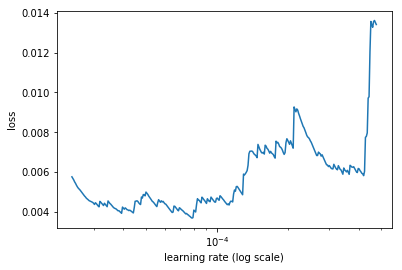

In [36]:
m.sched.plot(100)


In [45]:
m.fit(lr, 5 , cycle_len=1)


  0%|          | 5/1563 [00:00<01:53, 13.75it/s, loss=9.72e-05]

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/bahram/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bahram/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bahram/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.00022 0.     ]                                          
[1.      0.00075 0.     ]                                          
[2.      0.00016 0.     ]                                          
[3.      0.00033 0.     ]                                          
[4.     0.0003 0.    ]                                             

